In [70]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
import joblib
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [71]:
df = pd.read_csv("german_credit_data.csv")

In [72]:
#посмотрим на данные
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.3+ KB


In [74]:
#Признаки "Saving accounts" и "Checking account" содержать пропущенные значения, которые необходимо заполнить
df["Saving accounts"] = df["Saving accounts"].fillna("unknown")
df["Checking account"] = df["Checking account"].fillna("unknown")


In [75]:
#Закодируем категориальные признаки
#Для признаков "Saving accounts" и "Checking account" применим OrdinalEndcoder, т.к. порядок в них имеет значение, для остальных - LabelEncoder
ord1 = [["unknown", "little", "moderate", "rich"]]
ord2 = [["unknown", "little", "moderate", "quite rich", "rich"]]

oe1 = OrdinalEncoder(categories=ord1)
oe2 = OrdinalEncoder(categories=ord2)

df["Checking account"] = oe1.fit_transform(df[["Checking account"]])
df["Saving accounts"] = oe2.fit_transform(df[["Saving accounts"]])

for column in ['Sex', 'Housing', 'Purpose']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

df.head()


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,1,2,1,0.0,1.0,1169,6,5
1,1,22,0,2,1,1.0,2.0,5951,48,5
2,2,49,1,1,1,1.0,0.0,2096,12,3
3,3,45,1,2,0,1.0,1.0,7882,42,4
4,4,53,1,2,0,1.0,1.0,4870,24,1


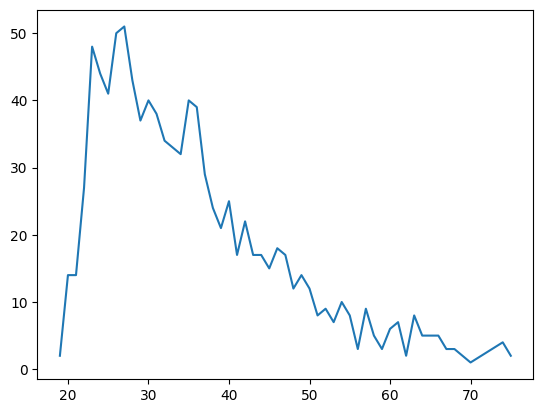

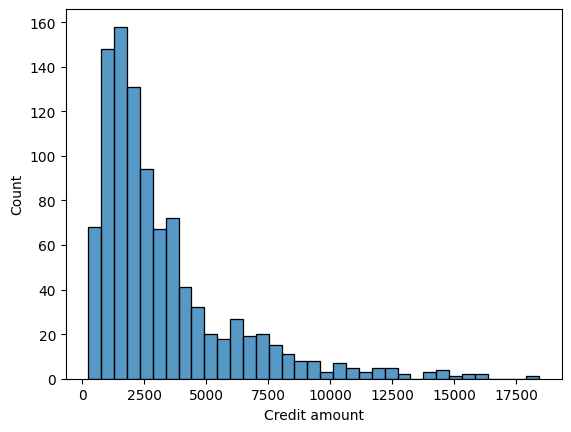

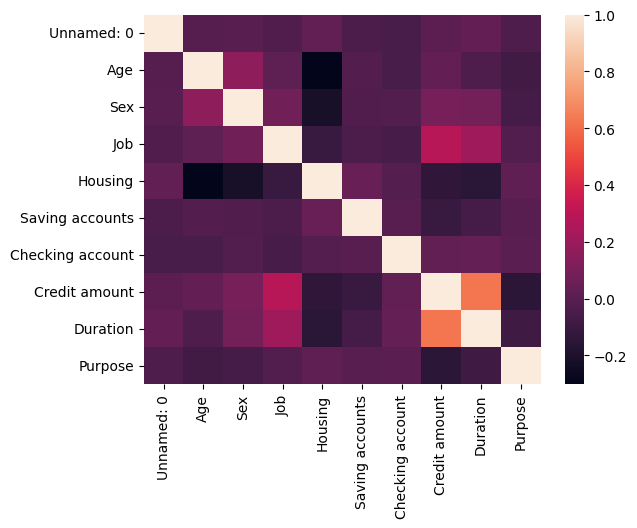

In [76]:
#Для лучшего представления о распределении данных, визуализируем их с помощью графиков
d = df["Age"].value_counts().to_dict()
sns.lineplot(x=d.keys(), y=d.values())
plt.show()

sns.histplot(df["Credit amount"])
plt.show()

sns.heatmap(df.corr())
plt.show()

In [77]:
#Разделим данные на тренировочную и тестовую выборки. 
#Будем считать, что заёмщику не стоит выдавать кредит (значение таргета 0) если сумма задолженности больше медианной
X = df.drop(columns=['Credit amount'])
y = df['Credit amount'] > df['Credit amount'].median() 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Для удобства воспользуемся z-стандартизацией

scl = StandardScaler()
X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)


In [78]:
#Обучим случайный лес

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

#Предскажем значения

y_pred = rf.predict(X_test)

In [79]:
#Оценим, насколько хорошо наша модель справляется с поставленной задачей. Для этого посчитаем accuracy, recall, precision и F-меру, а также 
#построим confusion matrix
acc = accuracy_score(y_test, y_pred)
print(acc)

confmat = confusion_matrix(y_test, y_pred)
print(confmat)

clrep = classification_report(y_test, y_pred)
print(clrep)


0.75
[[86 20]
 [30 64]]
              precision    recall  f1-score   support

       False       0.74      0.81      0.77       106
        True       0.76      0.68      0.72        94

    accuracy                           0.75       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.75      0.75      0.75       200



In [80]:
#Сохраним полученную модель
joblib.dump(rf, "rf.joblib")

['rf.joblib']

In [81]:
#Теперь попробуем применить градиентный бустинг, изменяя параметры модели

n_estimators = list(np.arange(10, 500, 50))
min_samples_leaf = list(np.arange(1, 20, 5))
max_depth = list(np.arange(1, 10, 3))

gridval = {'n_estimators': n_estimators, 'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth}

clf = GridSearchCV(GradientBoostingClassifier(), gridval, scoring = 'accuracy', cv = 5)
clf.fit(X_train, y_train)

best_n_estimators_value = clf.best_params_['n_estimators']
best_min_samples_leaf = clf.best_params_['min_samples_leaf']
best_max_depth = clf.best_params_['max_depth']
best_score = clf.best_score_

clf = RandomForestClassifier(n_estimators = best_n_estimators_value, max_depth = best_max_depth, min_samples_leaf = best_min_samples_leaf, random_state = 42)
clf.fit(X_train, y_train)

y_pred_boost = clf.predict(X_test)

#И посмотрим результат

acc_boost = accuracy_score(y_test, y_pred_boost)
print(acc_boost)

confmat_boost = confusion_matrix(y_test, y_pred_boost)
print(confmat_boost)

clrep_boost = classification_report(y_test, y_pred_boost)
print(clrep_boost)

0.745
[[86 20]
 [31 63]]
              precision    recall  f1-score   support

       False       0.74      0.81      0.77       106
        True       0.76      0.67      0.71        94

    accuracy                           0.74       200
   macro avg       0.75      0.74      0.74       200
weighted avg       0.75      0.74      0.74       200

